# Partition based time series clustering in aeon

Partition based clustering algorithms for time series are those where $k$
clusters are created from $n$ time series. The aim is to cluster so that each time
series in a cluster are homogenous (similar) to each other and heterogeneous
(dissimilar) to those outside the cluster.

Broadly speaking, clustering algorithms are either partitional or hierarchical. Partitional clustering algorithms assign (possibly probabilistic) cluster membership to each time series, usually through an iterative heuristic process of optimising some objective function that measures homogeneity.  Given a dataset of $n$ time series, $D$, the partitional time series clustering problem is to partition $D$ into $k$ clusters, $C = \{C_1, C_2, ..., C_k\}$ where $k$ is the number of clusters.

To measure homogeneity and place a time series into a cluster, a metric or distance is
used. For details of distances in aeon see the [distances examples](../distances/distances.ipynb). The distance is used to
compare a time series and assign cluster membership.

It is usually assumed that the number of clusters is set prior to the optimisation heuristic. If $k$ is not set, it is commonly found through some wrapper method. We assume $k$ is fixed in advance for all our experiments.

Currently, in aeon we have $k$-means with alternative averaging methods and
$k$-medoids with alternative medoids selection algorithms, and wrappers for tslearn
$k$-shapes and kernel $k$-means.


## Contents
1. $k$-partition clustering algorithms
1.1 Representative initialisation
1.2 Assignment (distance measure)
2. $k$-means clustering
2.1 Updating centroids
2.2 Example usage of $k$-means
3. $k$-medoids clustering
3.1. Partitioning Around the Medoids (PAM)
3.2. Alternating $k$-medoids (Lloyds)
3.3. Clustering LARge Applications (CLARA)
3.4. CLARA based raNdomised Search (CLARANS)
4. Performance comparison
5. Recreating results

In [11]:
# Imports and load data
from aeon.clustering import TimeSeriesKMeans, TimeSeriesKMedoids
from aeon.datasets import load_unit_test
from aeon.visualisation import plot_cluster_algorithm

X_train, y_train = load_unit_test(split="train")
(
    X_test,
    y_test,
) = load_unit_test(split="test")
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(20, 1, 24) (20,) (22, 1, 24) (22,)


## 1. $k$-partition clustering algorithms

$k$-partition clustering algorithms are those that seek to create $k$ clusters and
assign each time series to a cluster using a distance measure. A representative
series is created or selected to represent the centre of the cluster. In aeon the
following partitional clustering algorithms are currently supported:

- $k$-means - one of the most well known clustering algorithms. The goal of
the $k$-means algorithm is to minimise a criterion known as the inertia or
within-cluster sum-of-squares (uses the mean of the values in a cluster as
the centre). Each cluster is represented by some form of average of the cluster
members (the centroid).

- $k$-medoids - A similar algorithm to $k$-means but instead of using the average of
each cluster member to determine the centre, a representative time series is used
(the medoid).

Most partitional clustering algorithms follow an iterative greedy search involving
the following steps:
- Initialisation of cluster representatives
- Assignment of series to clusters based on distance to representatives
- Updating representatives to reflect new clusters
- Repeat assigment and updating until convergence

### 1.1 Representative initialisation

Representative initialisation is the first step and has been found to be critical in
obtaining good results. There are three commonly used initialisation strategies
available in aeon through the constructor argument `init`:
<ul>
    <li> Representative initialisation supported for $k$-means and $k$-medoids:
        <ul>
            <li>Random - This is where each sample in the training dataset is
            randomly assigned to a cluster and the update function is run based on
            these random assignments i.e. for k-means the mean of these
            randomly assigned clusters is used and for k-medoids the median of
            these randomly assigned clusters is used as the initial representative.</li>
            <li>Forgy - This simply selects $k$ random samples from the
            training dataset as the representatives.</li>
            <li>K-means++ - This is where the first representative is randomly chosen
            from the training dataset. The distance between all series and the first
           representative is found. The next representative is then chosen from the
            with probability proportional to the distance to the first representative (i
            .e. the greater the distance the more likely the time series will be
            chosen). The remaining
            centres are selected using the same method, using the nearest distance to
             representatives already chosen to find the probability of selection.
             This means that the selected representatives will proably be further
             apart from each other than randomly selected representatives.
            </li>
         </ul>
     </li>
 </ul>

In [12]:
temp = TimeSeriesKMeans(
    init="kmeans++",  # initialisation technique: random, or kmeans++
)
print(temp.init)

kmeans++


### 1.2 Assignment using a distance measure
How a time series is assigned to a cluster is based on its distance from it to the
cluster representatives. This means for some $k$-partition approaches, different
distance functions can be used to get different results. The following distance
functions are supported, and the constructor parameter value are  as follows:
<ul>
    <li>K-means, K-medoids supported distances:
        <ul>
            <li>Euclidean - parameter string 'euclidean'</li>
            <li>Manhattan - parameter string 'manhattan'</li>
            <li>DTW - parameter string 'dtw'</li>
            <li>DDTW - parameter string 'ddtw'</li>
            <li>WDTW - parameter string 'wdtw'</li>
            <li>WDDTW - parameter string 'wddtw'</li>
            <li>LCSS - parameter string 'lcss'</li>
            <li>ERP - parameter string 'erp'</li>
            <li>EDR - parameter string 'edr'</li>
            <li>MSM - parameter string 'msm'</li>
            <li>TWE - parameter string 'twe'</li>
        </ul>
    </li>
</ul>

The distance function can be set with the constructor argument `metric` for $k$-means
 and `distance` for $k$-medoids (we will unify this soon). The
distance function parameters can be set by passing a dictionary to
`distance_params`. Different distance functions may have different
distance parameters. Please see the [distances notebook](../distances/distances.ipynb) for more info
 on these functions and the [distance based clustering bake off](https://arxiv.org/abs/2205.15181) for further background and examples.

## 2. K-means clustering

One of the most popular TSCL approaches. The goal of the k-means algorithm is to
minimise a criterion known as the inertia or within-cluster sum-of-squares (uses the
mean of the values in a cluster as the centre). The best distance to use with k-means is MSM [1]_ and the best averaging technique to use is MBA (to do this see
above it is specified how to use barycentre averaging with MSM for k-means) [2]_.
Basic usage with DTW distance with a window parameter of 0.25 as follows:


In [13]:
TimeSeriesKMeans(
    distance="dtw",  # DTW distance with 25% warping allowed
    distance_params={"window": 0.25},
)

TimeSeriesKMeans(distance='dtw', distance_params={'window': 0.25})

### 2.1 Updating centroids

Updating centre representatives is key to how an algorithm improves the clustering.
It is also the most important difference between $k$-means and $k$-medoids.
$k$-means averages the current cluster members to update the centroid using one of
two methods:
<ul>
    <li> Mean average - This is a standard mean average creating a new
             series that is that average of all the series inside the cluster.
             If the metric is Euclidean distance, this makes Ideal when using euclidean
             distance. Can be specified to use
            by passing 'means' as the parameter for `averaging_algorithm` to
             k-means</li>
    <li> Barycentre averaging (BA) - This is a specialised
            averaging metric that is intended to be used with elastic
            distance measures. BA involves forming an alignment path between all
            cluster members and the current centroid. It then finds the values
            warped to each point and averages them, thus forming a new centroid. In
            principle, any elastic distance can be used with BA, although it is best
            known for use with Dynamic Time
            Warping (DTW) [6]. We also support its use with all distances by passing
            'ba' as the parameter for `averaging_algorithm` .
            </li>
</ul>

Note it is possible to mix and match distance functions and averaging methods,
although not advisable. The averaging method can be set with the `averaging_method`
for $k$-means. This can be a callable, or a string, that should be one of `mean`,
or`ba`.

In [14]:
temp = TimeSeriesKMeans(distance="euclidean", averaging_method="mean")
print(temp.get_params())
TimeSeriesKMeans(
    distance="msm", averaging_method="ba", average_params={"max_iters": 10}
)

{'average_params': None, 'averaging_method': 'mean', 'distance': 'euclidean', 'distance_params': None, 'init': 'random', 'init_algorithm': None, 'max_iter': 300, 'n_clusters': 8, 'n_init': 10, 'random_state': None, 'tol': 1e-06, 'verbose': False}


TimeSeriesKMeans(average_params={'max_iters': 10})

2.2 Example usage of $k$-means

We now put it all together to demonstrate how to use $k$-means. In addition
to the above parameters, $k$-means also has `max_iter` and `random_state` parameters.
 `max_iter` specifies the maximum number of iterations to allow.  `random_state`
 seeds the clusterer to make it deterministic.

(<Figure size 640x480 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

<Figure size 500x1000 with 0 Axes>

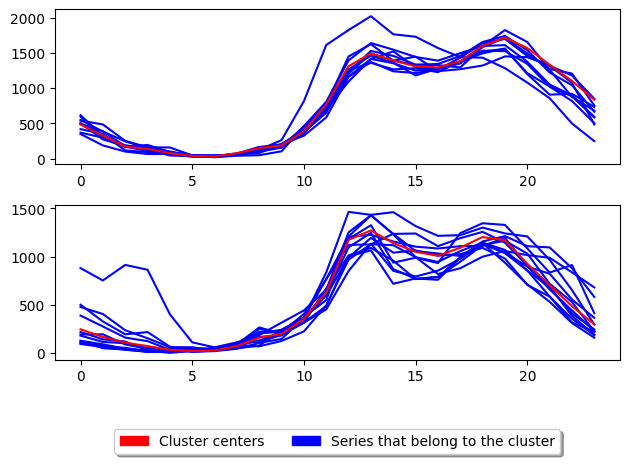

In [15]:
k_means = TimeSeriesKMeans(
    n_clusters=2,  # Number of desired centers
    init="random",  # initialisation technique: random, first or kmeans++
    max_iter=10,  # Maximum number of iterations for refinement on training set
    distance="dtw",  # Distance metric to use
    averaging_method="mean",  # Averaging technique to use
    random_state=1,  # Makes deterministic
)

k_means.fit(X_train)
plot_cluster_algorithm(k_means, X_test, k_means.n_clusters)

We have formed two clusters. The pattern of the two centroids seems fairly similar,
and the separation of clusters does not seem very good. We can score the clustering
with the score method, which by default returns `self.inertia_`, which is a measure
of between cluster variation used as a stopping condition.
For a range of clusteirng comparison algorithms, see the [sklearn clustering API]
(https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation)

Low intertia is better, so to conform to the sklearn interface which prefers to
maximize performance criteria, inertia scores are negative.


In [16]:
s1 = k_means.score(X_test, y_test)
s1

-5016911.727324263

 We think that best default configuration for  $k$-means is the msm metric with
barycentre averaging (see [1] for experimental support for this). We can configure
this as such:

(<Figure size 640x480 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

<Figure size 500x1000 with 0 Axes>

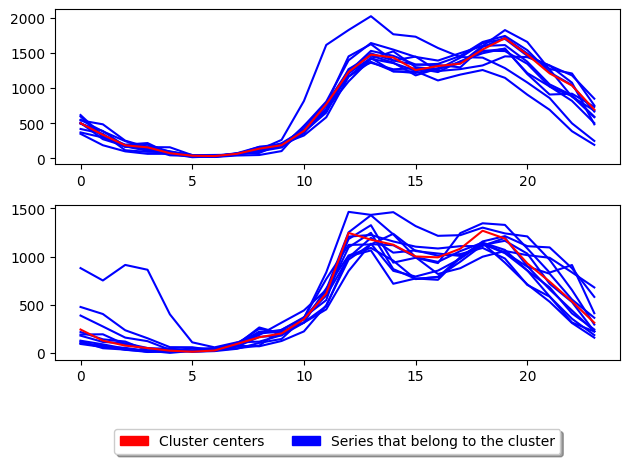

In [17]:
# Best configuration for k-means
k_means = TimeSeriesKMeans(
    n_clusters=2,  # Number of desired centers
    init="random",  # Center initialisation technique
    max_iter=10,  # Maximum number of iterations for refinement on training set
    distance="msm",  # Distance metric to use
    averaging_method="ba",  # Averaging technique to use
    random_state=1,
    average_params={
        "distance": "msm",
    },
)

k_means.fit(X_train)
plot_cluster_algorithm(k_means, X_test, k_means.n_clusters)

We have formed two clusters with barycentre averaging using MSM distance. The centroids
seem more distinct in shape now, with the first cluster centroid looking much
flatter than the second. The inertia has been reduced, so the score is higher.

In [18]:
s2 = k_means.score(X_test, y_test)
s2

-26178.727675421676

## 3. K-medoids clustering
$k$-medoids is another popular TSCL approach. The goal is to partition n
observations into $k$ clusters in which each observation belongs to the cluster with
the nearest medoid/centroid. There are two main variants which are PAM and alternate.
 PAM is the default and is the most accurate but is slower than alternate [3]. The
 best distance to use with all variants of k-medoids is MSM [1][3]. Basic usage is
 as follows:


In [19]:
temp2 = TimeSeriesKMedoids(
    distance="msm",  # MSM distance with c parameter set to 0.2 and 90% window.
    distance_params={"c": 2.0, "window": 0.9, "independent": True},
)
print(temp.distance, ", ", temp.distance_params)
print(temp2.distance, ", ", temp2.distance_params)

euclidean ,  None
msm ,  {'c': 2.0, 'window': 0.9, 'independent': True}


There are several variants of medoid based clustering algorithms in aeon:

3.1. Partitioning Around the Medoids (PAM): class `TimeSeriesKMedoids`, method = `pam`

3.2. Alternating $k$-medoids: class `TimeSeriesKMedoids`, method = `alternate`

3.3. Clustering LARge Applications (CLARA): class `TimeSeriesCLARA`

3.4. CLARA based raNdomised Search (CLARANS): class `TimeSeriesCLARANS`

We start with an example showing the important parameters and using DTW distance.

(<Figure size 640x480 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

<Figure size 500x1000 with 0 Axes>

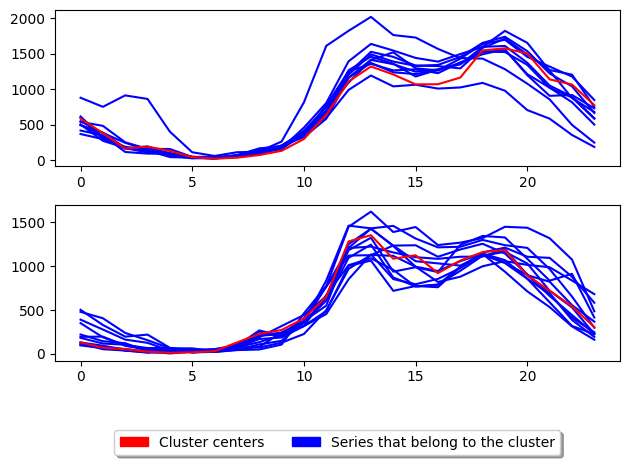

In [20]:
k_medoids = TimeSeriesKMedoids(
    n_clusters=2,  # Number of desired centers
    init_algorithm="random",  # Center initialisation technique
    max_iter=10,  # Maximum number of iterations for refinement on training set
    verbose=False,  # Verbose
    distance="dtw",  # Distance to use
    random_state=1,
)

k_medoids.fit(X_train)
s3 = k_medoids.score(X_test, y_test)
plot_cluster_algorithm(k_medoids, X_test, k_medoids.n_clusters)

### 3.1 Partitioning Around the Medoids (PAM): class `TimeSeriesKMedoids`, method =
`pam`

The  main distinguishing factor  of PAM is that in the rassigning of representative
centres (medoids) it allows cases to become medoids of clusters they are not
currently members of. This reduces the risk of premature convergence. Trying out all
case combinations of medoids is exponential in time complexity, so PAM employs an
heuristic. WE demonstrate the

The above shows the basic usage for K-medoids. `TimeSeriesKMedoids` uses
the partition around medoids (PAM) algorithm by default to update the centres.
The parameter key to k-medoids is the distance and is what we
can adjust to improve performance for time series. We have found that using MSM with
PAM produces better clusters on average [1]:


(<Figure size 640x480 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

<Figure size 500x1000 with 0 Axes>

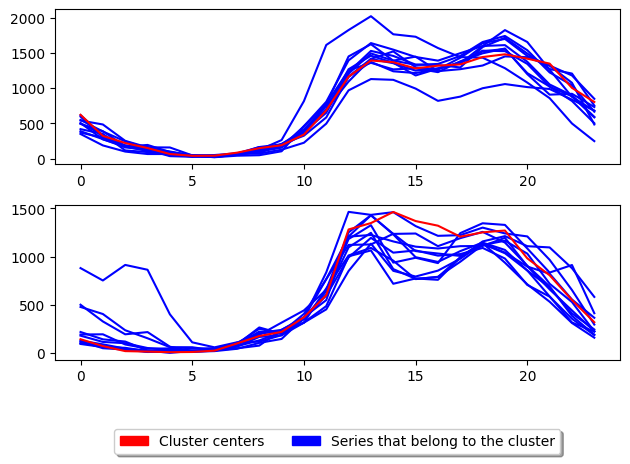

In [21]:
k_medoids = TimeSeriesKMedoids(
    n_clusters=2,  # Number of desired centers
    init_algorithm="random",  # Center initialisation technique
    max_iter=10,  # Maximum number of iterations for refinement on training set
    distance="msm",  # Distance to use
    random_state=1,
)

k_medoids.fit(X_train)
s4 = k_medoids.score(X_test, y_test)
plot_cluster_algorithm(k_medoids, X_test, k_medoids.n_clusters)

In [22]:
print(f" PAM DTW score {s3} PAM MSM score {s4}")

 PAM DTW score -5739730.0 PAM MSM score -25984.0


### 3.2 Alternate k-medoids
<p>In addition there is another popular way of performing k-medoids which is
using the alternate k-medoids algorithm. This method adapts the Lloyd's algorithm
(used in k-means) but instead of using the mean average to update the centres
it uses the medoid. This method is generally faster than PAM however it tends to be less
accurate. This method can be used by parsing 'alternate' as the parameter to
TimeSeriesKMedoids.</p>

Alternate MSM score =  -25984.0


<Figure size 500x1000 with 0 Axes>

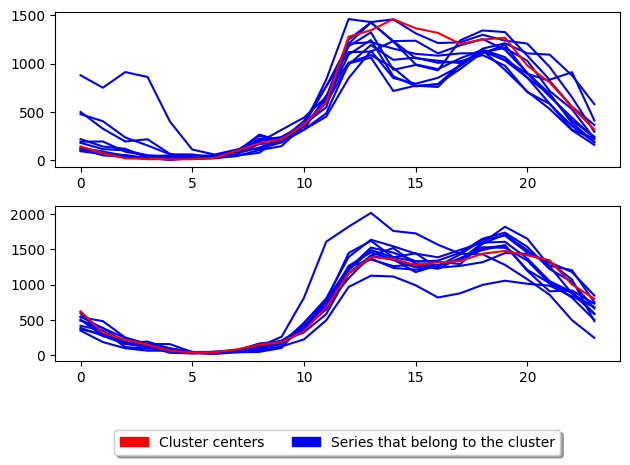

In [23]:
k_medoids = TimeSeriesKMedoids(
    n_clusters=2,  # Number of desired centers
    init_algorithm="random",  # Center initialisation technique
    max_iter=10,  # Maximum number of iterations for refinement on training set
    distance="msm",  # Distance to use
    random_state=1,
    method="alternate",
)

k_medoids.fit(X_train)
s5 = k_medoids.score(X_test, y_test)
plot_cluster_algorithm(k_medoids, X_test, k_medoids.n_clusters)
print("Alternate MSM score = ", s5)

<h3> 3.3 Clustering LARge Applications (CLARA): class `TimeSeriesCLARA`</h3>
<p> Clustering LARge Applications (CLARA)  [4]_ improves the run time performance of
PAM by only performing PAM on a subsample of the the dataset to generate the
cluster centres. This greatly improves the time taken to train the model however,
degrades the quality of the clusters.



(<Figure size 640x480 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

<Figure size 500x1000 with 0 Axes>

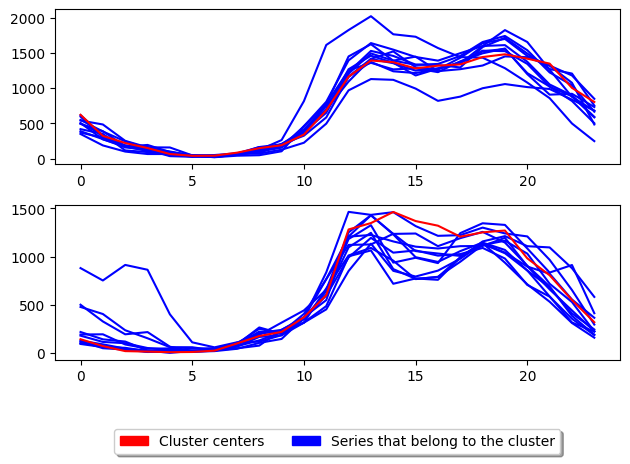

In [24]:
from aeon.clustering import TimeSeriesCLARA

clara = TimeSeriesCLARA(
    n_clusters=2,  # Number of desired centers
    max_iter=10,  # Maximum number of iterations for refinement on training set
    distance="msm",  # Distance to use
    random_state=1,
)
clara.fit(X_train)
s6 = k_medoids.score(X_test, y_test)
plot_cluster_algorithm(clara, X_test, clara.n_clusters)

### 3.4. CLARA based raNdomised Search (CLARANS): class `TimeSeriesCLARANS`
<p>    CLARA based raNdomised Search (CLARANS) [4] tries to improve the run time of
PAM by adapting the swap operation of PAM to
    use a more greedy approach. This is done by only performing the first swap which
    results in a reduction in total deviation before continuing evaluation. It limits
    the number of attempts known as max neighbours to randomly select and check if
    total deviation is reduced. This random selection gives CLARANS an advantage when


(<Figure size 640x480 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

<Figure size 500x1000 with 0 Axes>

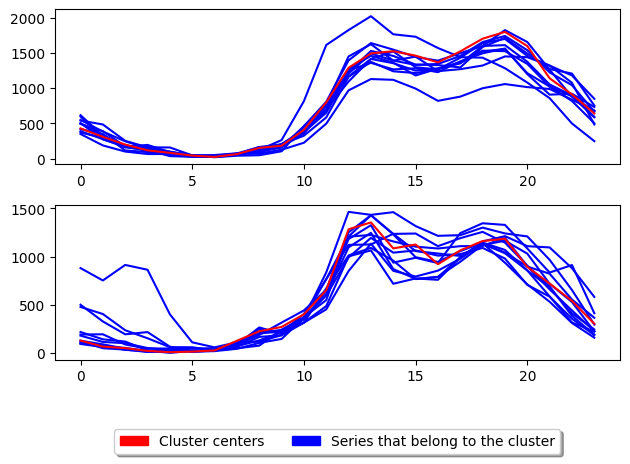

In [25]:
from aeon.clustering import TimeSeriesCLARANS

clara = TimeSeriesCLARANS(
    n_clusters=2,  # Number of desired centers
    distance="msm",  # Distance to use
    random_state=1,
)
clara.fit(X_train)
s7 = k_medoids.score(X_test, y_test)
plot_cluster_algorithm(clara, X_test, clara.n_clusters)

In [26]:
print(f" Clara score {s6} Clarans score = {s7}")

 Clara score -25984.0 Clarans score = -25984.0


## Performance comparison

We conducted a comparison of $k$-medoids and $k$-means with different distance
functions in [1][2][3]. We commonly use critical difference diagrams to compare
performance. The headline conclusions were

1. MSM is the most effective distance function [1]
2. PAM is on average better alternate for $k$-medoids
3. Barycentre averaging with MSM is better than using DBA [2]
4. $k$-medoids is generally better than $k$-means [3]

All the results to support these conclusions are (or will be) avaialable on the
aeon companion site [tsml archive](https://www.timeseriesclassification.com/). We can
download these results and recreate the performance comparison in `aeon`.


 Returned results in shape (111, 8)


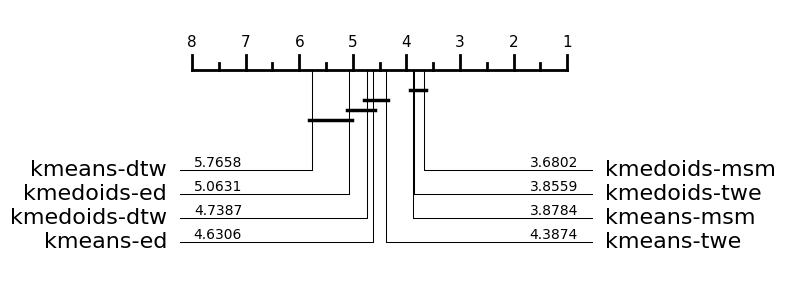

In [27]:
from aeon.benchmarking.results_loaders import get_estimator_results_as_array
from aeon.visualisation import plot_critical_difference

# 1. MSM is the most effective distance function
clusterers = [
    "kmeans-ed",
    "kmeans-dtw",
    "kmeans-msm",
    "kmeans-twe",
    "kmedoids-ed",
    "kmedoids-dtw",
    "kmedoids-msm",
    "kmedoids-twe",
]
accuracy, data_names = get_estimator_results_as_array(
    task="clustering", estimators=clusterers, measure="clacc"
)
print(f" Returned results in shape {accuracy.shape}")
plt = plot_critical_difference(accuracy, clusterers)

We have pulled down the test accuracies from the website for eight clustering
algorithms for 111 datsets. the number of above each line is the average rank of each
 algorithm

### References

[1] Christopher Holder, Matthew Middlehurst, and Anthony Bagnall. A Review and
Evaluation of Elastic Distance Functions for Time Series Clustering,  Knowledge and Information Systems. In Press (2023)

[2] Christopher Holder, David Guijo-Rubio, and Anthony Bagnall. Barycentre averaging
for the move-split-merge time series distance measure. 15th International Joint
Conference on Knowledge Discovery, Knowledge Engineering and Knowledge Management (2023)

[3] Christopher Holder, David Guijo-Rubio, and Anthony Bagnall. "Clustering time
series with k-medoids based algorithms" 8th Workshop on Advanced Analytics and
Learning on Temporal Data (AALTD) at ECML-PKDD (2023)

[4] Kaufman, Leonard & Rousseeuw, Peter. (1986). Clustering Large Data Sets. 10.1016/B978-0-444-87877-9.50039-X.

[5] R. T. Ng and Jiawei Han, "CLARANS: a method for clustering objects spatial data mining," in IEEE Transactions on Knowledge and Data Engineering vol. 14, no. 5, pp. 1003-1016, Sept.-Oct. 2002, doi: 10.1109/TKDE.2002.1033770.

[6] F. Petitjean, A. Ketterlin and P. Gancarski, "A global averaging method for dynamic time warping,
with applications to clustering", Pattern Recognition, vol. 44, pp. 678-693, 2011
